# RMSE

## Tuning for RMSE & Plot test RMSE

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time

# ===============================
# 1. Set Random Seed
# ===============================
tf.random.set_seed(42)
np.random.seed(42)

# ===============================
# 2. Load Data
# ===============================
ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

movies = pd.read_csv(
    'u.item',
    sep='|',
    encoding='latin-1',
    names=['item_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{i}' for i in range(19)],
    usecols=range(24)
)

users = pd.read_csv(
    'u.user',
    sep='|',
    names=['user_id', 'age', 'gender', 'occupation', 'zip_code']
)

# ===============================
# 3. Preprocessing
# ===============================
ratings = ratings.sort_values('timestamp').drop_duplicates(subset=['user_id', 'item_id'], keep='last')
ratings = ratings.merge(movies, on='item_id')
ratings = ratings.merge(users[['user_id', 'age', 'gender', 'occupation']], on='user_id')

# --- Mean Center and Normalize Ratings per User ---
user_mean = ratings.groupby('user_id')['rating'].mean()
ratings['user_mean'] = ratings['user_id'].map(user_mean)
ratings['mean_centered_rating'] = ratings['rating'] - ratings['user_mean']

# Normalize mean-centered ratings to [-1, 1] using max absolute deviation per user
user_max_dev = ratings.groupby('user_id')['mean_centered_rating'].apply(lambda x: x.abs().max())
ratings['user_max_dev'] = ratings['user_id'].map(user_max_dev)

# Avoid division by zero for constant ratings
ratings['user_max_dev'] = ratings['user_max_dev'].replace(0, 1)

ratings['normalized_rating'] = ratings['mean_centered_rating'] / ratings['user_max_dev']

# --- Encode Features ---
genre_cols = [f'genre_{i}' for i in range(19)]
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
ratings['user'] = user_encoder.fit_transform(ratings['user_id'])
ratings['movie'] = movie_encoder.fit_transform(ratings['item_id'])
ratings['gender'] = ratings['gender'].map({'M': 0, 'F': 1})
ratings['occupation'] = ratings['occupation'].astype('category').cat.codes

n_users = ratings['user'].nunique()
n_movies = ratings['movie'].nunique()
n_occupations = len(ratings['occupation'].unique())


# ===============================
# 4. Train-Test Split by User
# ===============================
train_rows, test_rows = [], []
for _, user_ratings in ratings.groupby('user_id'):
    if len(user_ratings) < 5:
        train_rows.append(user_ratings)
    else:
        train, test = train_test_split(user_ratings, test_size=0.2, random_state=42)
        train_rows.append(train)
        test_rows.append(test)

train_df = pd.concat(train_rows).reset_index(drop=True)
test_df = pd.concat(test_rows).reset_index(drop=True)
# ===============================
# 5. Dataset Builder
# ===============================
def build_dataset(df):
    return tf.data.Dataset.from_tensor_slices((
        {
            "user_id": df['user'].values,
            "movie_id": df['movie'].values,
            "age": df['age'].values.astype(np.float32).reshape(-1, 1),
            "gender": df['gender'].values,
            "occupation": df['occupation'].values,
            "genres": df[genre_cols].values.astype(np.float32)
        },
        df['normalized_rating'].values.astype(np.float32)
    )).batch(1024).prefetch(tf.data.AUTOTUNE)

train_dataset = build_dataset(train_df)
test_dataset = build_dataset(test_df)

# ===============================
# 6. Model: genre_dense_size tied to embedding_size
# ===============================
class RecommenderNet(tf.keras.Model):
    def __init__(self, n_users, n_movies, embedding_size, user_dense_size, movie_dense_size, final_dim):
        super(RecommenderNet, self).__init__()

        # User tower
        self.user_embedding = tf.keras.layers.Embedding(n_users, embedding_size)
        self.gender_embedding = tf.keras.layers.Embedding(2, embedding_size // 2)
        self.occupation_embedding = tf.keras.layers.Embedding(n_occupations, embedding_size // 2)
        self.age_normalization = tf.keras.layers.Normalization()
        self.age_dense = tf.keras.layers.Dense(embedding_size // 2, activation="relu")
        self.user_dense = tf.keras.layers.Dense(user_dense_size, activation="relu")
        self.user_final = tf.keras.layers.Dense(final_dim)

        # Movie tower
        self.movie_embedding = tf.keras.layers.Embedding(n_movies, embedding_size)
        self.genre_dense = tf.keras.layers.Dense(embedding_size, activation="relu")  # Tied to embedding_size
        self.movie_dense = tf.keras.layers.Dense(movie_dense_size, activation="relu")
        self.movie_final = tf.keras.layers.Dense(final_dim)

    def call(self, inputs):
        user_vec = self.user_embedding(inputs["user_id"])
        gender_vec = self.gender_embedding(inputs["gender"])
        occupation_vec = self.occupation_embedding(inputs["occupation"])
        age_vec = self.age_dense(self.age_normalization(inputs["age"]))

        user_features = tf.concat([user_vec, gender_vec, occupation_vec, age_vec], axis=1)
        user_features = self.user_dense(user_features)
        user_features = self.user_final(user_features)

        movie_vec = self.movie_embedding(inputs["movie_id"])
        genre_vec = self.genre_dense(inputs["genres"])
        movie_features = tf.concat([movie_vec, genre_vec], axis=1)
        movie_features = self.movie_dense(movie_features)
        movie_features = self.movie_final(movie_features)

        user_norm = tf.math.l2_normalize(user_features, axis=1)
        movie_norm = tf.math.l2_normalize(movie_features, axis=1)
        return tf.reduce_sum(user_norm * movie_norm, axis=1)

# ===============================
# 7. Train/Evaluate
# ===============================
def train_and_evaluate_model(embedding_size, user_dense_size, movie_dense_size, final_dim):
    tf.keras.backend.clear_session()
    model = RecommenderNet(n_users, n_movies, embedding_size, user_dense_size, movie_dense_size, final_dim)
    model.age_normalization.adapt(train_df['age'].values.astype(np.float32).reshape(-1, 1))

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.MeanSquaredError())
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=10, verbose=0)

    train_preds = model.predict(train_dataset)
    test_preds = model.predict(test_dataset)

    return {
        'train_rmse': np.sqrt(mean_squared_error(train_df['normalized_rating'], train_preds)),
        'test_rmse': np.sqrt(mean_squared_error(test_df['normalized_rating'], test_preds)),
        'val_loss_curve': history.history['val_loss'],
    }

# ===============================
# 8. Experiment Grid (no genre_dense_size)
# ===============================
embedding_sizes = [16, 32, 64]
user_dense_sizes = [8, 16, 32, 64, 128]
movie_dense_sizes = [8, 16, 32, 64, 128]
final_dims = [64, 128]

experiments = [
    {
        'embedding_size': emb,
        'user_dense_size': uds,
        'movie_dense_size': mds,
        'final_dim': fd
    }
    for emb, uds, mds, fd in product(
        embedding_sizes, user_dense_sizes, movie_dense_sizes, final_dims
    )
]

# ===============================
# 9. Run Experiments
# ===============================
results = {}
start_time = time.time()
for config in experiments:
    key = f"emb{config['embedding_size']}_user{config['user_dense_size']}_movie{config['movie_dense_size']}_final{config['final_dim']}"
    print(f"Running: {key}")
    results[key] = train_and_evaluate_model(**config)
end_time = time.time()
print(f"Total time taken: {(end_time - start_time):.2f} seconds.")

# ===============================
# 10. Plot Test RMSE
# ===============================
def plot_test_rmse(results):
    keys = list(results.keys())
    rmse_values = [results[k]['test_rmse'] for k in keys]

    plt.figure(figsize=(12, 5))
    plt.plot(rmse_values, marker='o', label='Test RMSE')
    plt.xticks(ticks=range(len(keys)), labels=keys, rotation=90)
    plt.ylabel("RMSE")
    plt.title("Test RMSE across parameter settings")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_test_rmse(results)

# ===============================
# 11. Top/Bottom 5
# ===============================
def print_top_bottom(results):
    sorted_by_rmse = sorted(results.items(), key=lambda x: x[1]['test_rmse'])

    print("\nTop 5 by RMSE:")
    for k, v in sorted_by_rmse[:5]:
        print(f"{k}: Test RMSE={v['test_rmse']:.4f}, Train RMSE={v['train_rmse']:.4f}")

    print("\nBottom 5 by RMSE:")
    for k, v in sorted_by_rmse[-5:]:
        print(f"{k}: Test RMSE={v['test_rmse']:.4f}, Train RMSE={v['train_rmse']:.4f}")

print_top_bottom(results)

Running: emb16_user8_movie8_final64
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie8_final128
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie16_final64
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie16_final128
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie32_final64
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie32_final128
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie64_final64
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie64_final128
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie128_final64
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2

## Plot train RMSE [for information]

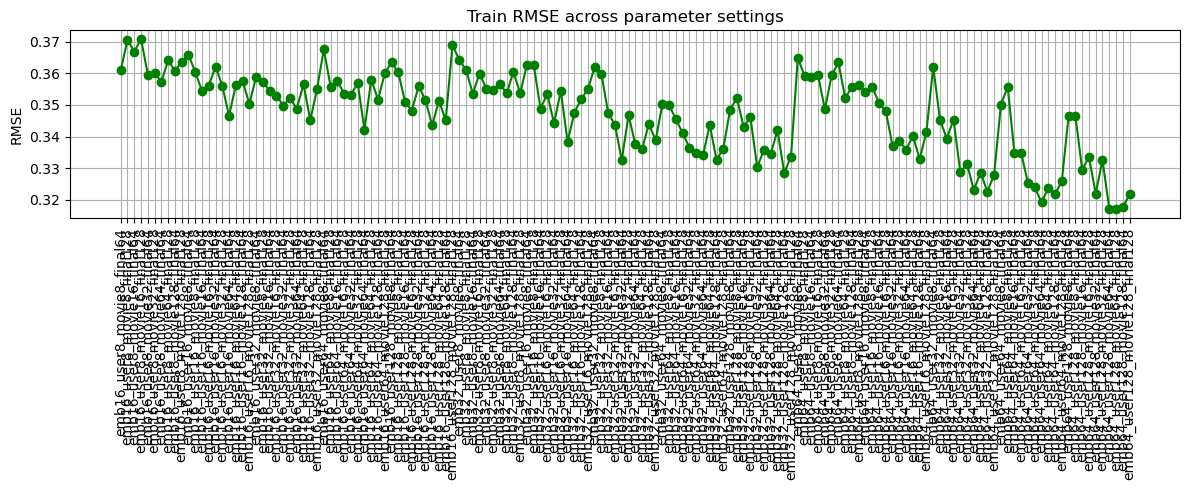


Top 5 by Train RMSE:
emb64_user128_movie64_final128: Train RMSE=0.3170, Test RMSE=0.3967
emb64_user128_movie64_final64: Train RMSE=0.3172, Test RMSE=0.3997
emb64_user128_movie128_final64: Train RMSE=0.3177, Test RMSE=0.3994
emb64_user64_movie64_final64: Train RMSE=0.3192, Test RMSE=0.3968
emb64_user128_movie128_final128: Train RMSE=0.3217, Test RMSE=0.3987

Bottom 5 by Train RMSE:
emb16_user8_movie16_final64: Train RMSE=0.3668, Test RMSE=0.3963
emb16_user64_movie8_final64: Train RMSE=0.3676, Test RMSE=0.3961
emb16_user128_movie128_final128: Train RMSE=0.3691, Test RMSE=0.4044
emb16_user8_movie8_final128: Train RMSE=0.3706, Test RMSE=0.3958
emb16_user8_movie16_final128: Train RMSE=0.3709, Test RMSE=0.4009


In [ ]:
# ===============================
# 10. Plot Train RMSE
# ===============================
def plot_train_rmse(results):
    keys = list(results.keys())
    rmse_values = [results[k]['train_rmse'] for k in keys]

    plt.figure(figsize=(12, 5))
    plt.plot(rmse_values, marker='o', color='green', label='Train RMSE')
    plt.xticks(ticks=range(len(keys)), labels=keys, rotation=90)
    plt.ylabel("RMSE")
    plt.title("Train RMSE across parameter settings")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_train_rmse(results)

# ===============================
# 11. Print Top/Bottom 5 by Train RMSE
# ===============================
def print_top_bottom_train(results):
    sorted_by_train_rmse = sorted(results.items(), key=lambda x: x[1]['train_rmse'])

    print("\nTop 5 by Train RMSE:")
    for k, v in sorted_by_train_rmse[:5]:
        print(f"{k}: Train RMSE={v['train_rmse']:.4f}, Test RMSE={v['test_rmse']:.4f}")

    print("\nBottom 5 by Train RMSE:")
    for k, v in sorted_by_train_rmse[-5:]:
        print(f"{k}: Train RMSE={v['train_rmse']:.4f}, Test RMSE={v['test_rmse']:.4f}")

print_top_bottom_train(results)


## MAE

## Tuning with MAE

Running: emb16_user8_movie8_final64
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie8_final128
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie16_final64
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie16_final128
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie32_final64
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie32_final128
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie64_final64
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie64_final128
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running: emb16_user8_movie128_final64
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2

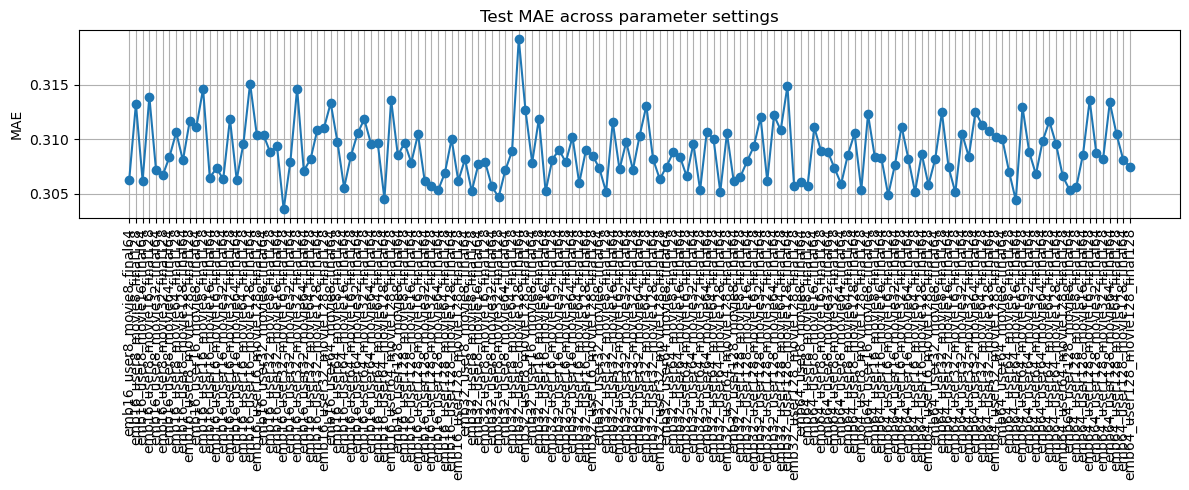


Top 5 by MAE:
emb16_user32_movie16_final128: Test MAE=0.3036, Train MAE=0.2761
emb64_user64_movie16_final64: Test MAE=0.3044, Train MAE=0.2583
emb16_user64_movie128_final64: Test MAE=0.3045, Train MAE=0.2746
emb32_user8_movie32_final128: Test MAE=0.3047, Train MAE=0.2785
emb64_user16_movie16_final128: Test MAE=0.3049, Train MAE=0.2695

Bottom 5 by MAE:
emb16_user16_movie8_final128: Test MAE=0.3146, Train MAE=0.2931
emb16_user32_movie32_final128: Test MAE=0.3146, Train MAE=0.2827
emb32_user128_movie128_final64: Test MAE=0.3148, Train MAE=0.2672
emb16_user16_movie128_final64: Test MAE=0.3151, Train MAE=0.2873
emb32_user8_movie128_final64: Test MAE=0.3192, Train MAE=0.2916


In [ ]:
from sklearn.metrics import mean_absolute_error
class RecommenderNet(tf.keras.Model):
    def __init__(self, n_users, n_movies, embedding_size, user_dense_size, movie_dense_size, final_dim):
        super(RecommenderNet, self).__init__()

        # User tower
        self.user_embedding = tf.keras.layers.Embedding(n_users, embedding_size)
        self.gender_embedding = tf.keras.layers.Embedding(2, embedding_size // 2)
        self.occupation_embedding = tf.keras.layers.Embedding(n_occupations, embedding_size // 2)
        self.age_normalization = tf.keras.layers.Normalization()
        self.age_dense = tf.keras.layers.Dense(embedding_size // 2, activation="relu")
        self.user_dense = tf.keras.layers.Dense(user_dense_size, activation="relu")
        self.user_final = tf.keras.layers.Dense(final_dim)

        # Movie tower
        self.movie_embedding = tf.keras.layers.Embedding(n_movies, embedding_size)
        self.genre_dense = tf.keras.layers.Dense(embedding_size, activation="relu")
        self.movie_dense = tf.keras.layers.Dense(movie_dense_size, activation="relu")
        self.movie_final = tf.keras.layers.Dense(final_dim)

    def call(self, inputs):
        user_vec = self.user_embedding(inputs["user_id"])
        gender_vec = self.gender_embedding(inputs["gender"])
        occupation_vec = self.occupation_embedding(inputs["occupation"])
        age_vec = self.age_dense(self.age_normalization(inputs["age"]))

        user_features = tf.concat([user_vec, gender_vec, occupation_vec, age_vec], axis=1)
        user_features = self.user_dense(user_features)
        user_features = self.user_final(user_features)

        movie_vec = self.movie_embedding(inputs["movie_id"])
        genre_vec = self.genre_dense(inputs["genres"])
        movie_features = tf.concat([movie_vec, genre_vec], axis=1)
        movie_features = self.movie_dense(movie_features)
        movie_features = self.movie_final(movie_features)

        user_norm = tf.math.l2_normalize(user_features, axis=1)
        movie_norm = tf.math.l2_normalize(movie_features, axis=1)
        return tf.reduce_sum(user_norm * movie_norm, axis=1)

# ===============================
# 7. Train/Evaluate using MAE
# ===============================
def train_and_evaluate_model(embedding_size, user_dense_size, movie_dense_size, final_dim):
    tf.keras.backend.clear_session()
    model = RecommenderNet(n_users, n_movies, embedding_size, user_dense_size, movie_dense_size, final_dim)
    model.age_normalization.adapt(train_df['age'].values.astype(np.float32).reshape(-1, 1))

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.MeanAbsoluteError())
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=10, verbose=0)

    train_preds = model.predict(train_dataset)
    test_preds = model.predict(test_dataset)

    return {
        'train_mae': mean_absolute_error(train_df['normalized_rating'], train_preds),
        'test_mae': mean_absolute_error(test_df['normalized_rating'], test_preds),
        'val_loss_curve': history.history['val_loss'],
    }

# ===============================
# 8. Experiment Grid
# ===============================
embedding_sizes = [16, 32, 64]
user_dense_sizes = [8, 16, 32, 64, 128]
movie_dense_sizes = [8, 16, 32, 64, 128]
final_dims = [64, 128]

experiments = [
    {
        'embedding_size': emb,
        'user_dense_size': uds,
        'movie_dense_size': mds,
        'final_dim': fd
    }
    for emb, uds, mds, fd in product(
        embedding_sizes, user_dense_sizes, movie_dense_sizes, final_dims
    )
]

# ===============================
# 9. Run Experiments
# ===============================
results = {}
start_time = time.time()
for config in experiments:
    key = f"emb{config['embedding_size']}_user{config['user_dense_size']}_movie{config['movie_dense_size']}_final{config['final_dim']}"
    print(f"Running: {key}")
    results[key] = train_and_evaluate_model(**config)
end_time = time.time()
print(f"Total time taken: {(end_time - start_time):.2f} seconds.")

# ===============================
# 10. Plot Test MAE
# ===============================
def plot_test_mae(results):
    keys = list(results.keys())
    mae_values = [results[k]['test_mae'] for k in keys]

    plt.figure(figsize=(12, 5))
    plt.plot(mae_values, marker='o', label='Test MAE')
    plt.xticks(ticks=range(len(keys)), labels=keys, rotation=90)
    plt.ylabel("MAE")
    plt.title("Test MAE across parameter settings")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_test_mae(results)

# ===============================
# 11. Top/Bottom 5 by MAE
# ===============================
def print_top_bottom(results):
    sorted_by_mae = sorted(results.items(), key=lambda x: x[1]['test_mae'])

    print("\nTop 5 by MAE:")
    for k, v in sorted_by_mae[:5]:
        print(f"{k}: Test MAE={v['test_mae']:.4f}, Train MAE={v['train_mae']:.4f}")

    print("\nBottom 5 by MAE:")
    for k, v in sorted_by_mae[-5:]:
        print(f"{k}: Test MAE={v['test_mae']:.4f}, Train MAE={v['train_mae']:.4f}")

print_top_bottom(results)

## Plotting training with MAE [For information]

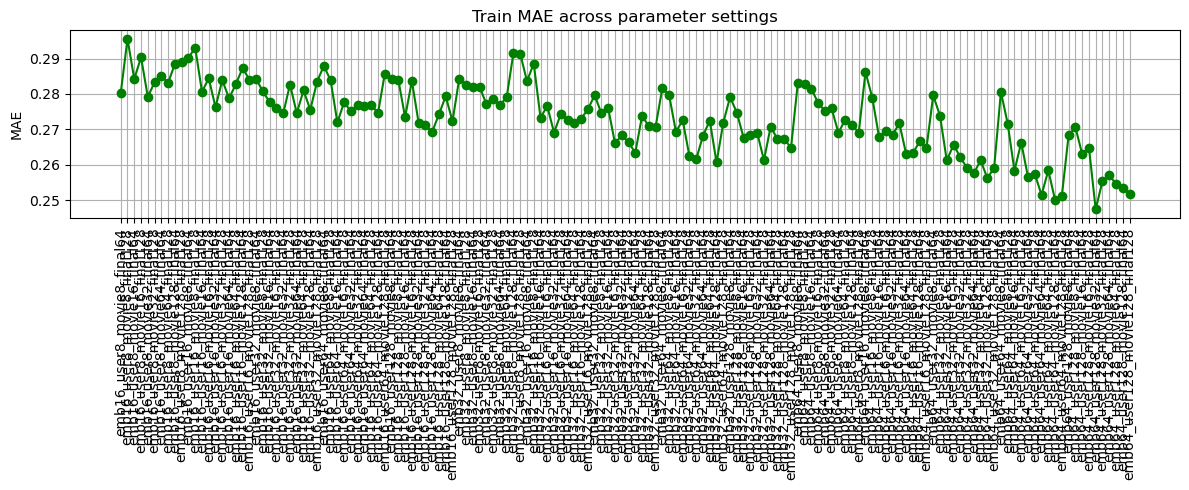


Top 5 by Train MAE:
emb64_user128_movie32_final64: Train MAE=0.2474, Test MAE=0.3087
emb64_user64_movie128_final64: Train MAE=0.2500, Test MAE=0.3095
emb64_user64_movie128_final128: Train MAE=0.2512, Test MAE=0.3066
emb64_user64_movie64_final64: Train MAE=0.2514, Test MAE=0.3098
emb64_user128_movie128_final128: Train MAE=0.2518, Test MAE=0.3075

Bottom 5 by Train MAE:
emb16_user8_movie16_final128: Train MAE=0.2904, Test MAE=0.3139
emb32_user8_movie128_final128: Train MAE=0.2914, Test MAE=0.3127
emb32_user8_movie128_final64: Train MAE=0.2916, Test MAE=0.3192
emb16_user16_movie8_final128: Train MAE=0.2931, Test MAE=0.3146
emb16_user8_movie8_final128: Train MAE=0.2956, Test MAE=0.3132


In [ ]:
def plot_train_mae(results):
    keys = list(results.keys())
    mae_values = [results[k]['train_mae'] for k in keys]

    plt.figure(figsize=(12, 5))
    plt.plot(mae_values, marker='o', color='green', label='Train MAE')
    plt.xticks(ticks=range(len(keys)), labels=keys, rotation=90)
    plt.ylabel("MAE")
    plt.title("Train MAE across parameter settings")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_train_mae(results)
def print_top_bottom_train_mae(results):
    sorted_by_train_mae = sorted(results.items(), key=lambda x: x[1]['train_mae'])

    print("\nTop 5 by Train MAE:")
    for k, v in sorted_by_train_mae[:5]:
        print(f"{k}: Train MAE={v['train_mae']:.4f}, Test MAE={v['test_mae']:.4f}")

    print("\nBottom 5 by Train MAE:")
    for k, v in sorted_by_train_mae[-5:]:
        print(f"{k}: Train MAE={v['train_mae']:.4f}, Test MAE={v['test_mae']:.4f}")
print_top_bottom_train_mae(results)

## Finalize Model

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time

# ===============================
# 1. Set Random Seed
# ===============================
tf.random.set_seed(42)
np.random.seed(42)

# ===============================
# 2. Load Data
# ===============================
ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

movies = pd.read_csv(
    'u.item',
    sep='|',
    encoding='latin-1',
    names=['item_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{i}' for i in range(19)],
    usecols=range(24)
)

users = pd.read_csv(
    'u.user',
    sep='|',
    names=['user_id', 'age', 'gender', 'occupation', 'zip_code']
)

# ===============================
# 3. Preprocessing
# ===============================
ratings = ratings.sort_values('timestamp').drop_duplicates(subset=['user_id', 'item_id'], keep='last')
ratings = ratings.merge(movies, on='item_id')
ratings = ratings.merge(users[['user_id', 'age', 'gender', 'occupation']], on='user_id')

# --- Mean Center and Normalize Ratings per User ---
user_mean = ratings.groupby('user_id')['rating'].mean()
ratings['user_mean'] = ratings['user_id'].map(user_mean)
ratings['mean_centered_rating'] = ratings['rating'] - ratings['user_mean']

# Normalize mean-centered ratings to [-1, 1] using max absolute deviation per user
user_max_dev = ratings.groupby('user_id')['mean_centered_rating'].apply(lambda x: x.abs().max())
ratings['user_max_dev'] = ratings['user_id'].map(user_max_dev)

# Avoid division by zero for constant ratings
ratings['user_max_dev'] = ratings['user_max_dev'].replace(0, 1)

ratings['normalized_rating'] = ratings['mean_centered_rating'] / ratings['user_max_dev']

# --- Encode Features ---
genre_cols = [f'genre_{i}' for i in range(19)]
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
ratings['user'] = user_encoder.fit_transform(ratings['user_id'])
ratings['movie'] = movie_encoder.fit_transform(ratings['item_id'])
ratings['gender'] = ratings['gender'].map({'M': 0, 'F': 1})
ratings['occupation'] = ratings['occupation'].astype('category').cat.codes

n_users = ratings['user'].nunique()
n_movies = ratings['movie'].nunique()
n_occupations = len(ratings['occupation'].unique())


# ===============================
# 4. Train-Test Split by User
# ===============================
train_rows, test_rows = [], []
for _, user_ratings in ratings.groupby('user_id'):
    if len(user_ratings) < 5:
        train_rows.append(user_ratings)
    else:
        train, test = train_test_split(user_ratings, test_size=0.2, random_state=42)
        train_rows.append(train)
        test_rows.append(test)

train_df = pd.concat(train_rows).reset_index(drop=True)
test_df = pd.concat(test_rows).reset_index(drop=True)
# ===============================
# 5. Dataset Builder
# ===============================
def build_dataset(df):
    return tf.data.Dataset.from_tensor_slices((
        {
            "user_id": df['user'].values,
            "movie_id": df['movie'].values,
            "age": df['age'].values.astype(np.float32).reshape(-1, 1),
            "gender": df['gender'].values,
            "occupation": df['occupation'].values,
            "genres": df[genre_cols].values.astype(np.float32)
        },
        df['normalized_rating'].values.astype(np.float32)
    )).batch(1024).prefetch(tf.data.AUTOTUNE)

train_dataset = build_dataset(train_df)
test_dataset = build_dataset(test_df)


In [ ]:
import tensorflow as tf
import numpy as np
import time
from sklearn.metrics import mean_squared_error

class RecommenderNet(tf.keras.Model):
    def __init__(self, n_users, n_movies, n_occupations,
                 embedding_size=16,
                 user_dense_size=16,
                 genre_dense_size=16,  # tied to embedding_size
                 movie_dense_size=64,
                 final_dim=64):
        super(RecommenderNet, self).__init__()

        # User tower
        self.user_embedding = tf.keras.layers.Embedding(n_users, embedding_size)
        self.gender_embedding = tf.keras.layers.Embedding(2, embedding_size // 2)
        self.occupation_embedding = tf.keras.layers.Embedding(n_occupations, embedding_size // 2)
        self.age_normalization = tf.keras.layers.Normalization()
        self.age_dense = tf.keras.layers.Dense(embedding_size // 2, activation="relu")
        self.user_dense = tf.keras.layers.Dense(user_dense_size, activation="relu")
        self.user_final = tf.keras.layers.Dense(final_dim)

        # Movie tower
        self.movie_embedding = tf.keras.layers.Embedding(n_movies, embedding_size)
        self.genre_dense = tf.keras.layers.Dense(genre_dense_size, activation="relu")
        self.movie_dense = tf.keras.layers.Dense(movie_dense_size, activation="relu")
        self.movie_final = tf.keras.layers.Dense(final_dim)

    def call(self, inputs):
        user_vec = self.user_embedding(inputs["user_id"])
        gender_vec = self.gender_embedding(inputs["gender"])
        occupation_vec = self.occupation_embedding(inputs["occupation"])
        age_vec = self.age_dense(self.age_normalization(inputs["age"]))

        user_features = tf.concat([user_vec, gender_vec, occupation_vec, age_vec], axis=1)
        user_features = self.user_dense(user_features)
        user_features = self.user_final(user_features)

        movie_vec = self.movie_embedding(inputs["movie_id"])
        genre_vec = self.genre_dense(inputs["genres"])
        movie_features = tf.concat([movie_vec, genre_vec], axis=1)
        movie_features = self.movie_dense(movie_features)
        movie_features = self.movie_final(movie_features)

        user_norm = tf.math.l2_normalize(user_features, axis=1)
        movie_norm = tf.math.l2_normalize(movie_features, axis=1)
        return tf.reduce_sum(user_norm * movie_norm, axis=1)


# Instantiate & Compile Model
model = RecommenderNet(
    n_users=n_users,
    n_movies=n_movies,
    n_occupations=len(ratings['occupation'].unique()),
    embedding_size=64,
    user_dense_size=128,
    genre_dense_size=64,
    movie_dense_size=32,
    final_dim=128
)

model.age_normalization.adapt(train_df['age'].values.astype(np.float32).reshape(-1, 1))

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

# Train Model
start_time = time.time()
history = model.fit(train_dataset, validation_data=test_dataset, epochs=50)
end_time = time.time()
print(f"Training took {(end_time - start_time):.2f} seconds.")

# Evaluate Final Model (RMSE)

train_preds = model.predict(train_dataset)
train_rmse = np.sqrt(mean_squared_error(train_df['normalized_rating'].values, train_preds))
print(f"Train RMSE: {train_rmse:.4f}")

test_preds = model.predict(test_dataset)
test_rmse = np.sqrt(mean_squared_error(test_df['normalized_rating'].values, test_preds))
print(f"Test RMSE: {test_rmse:.4f}")


Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.1863 - val_loss: 0.1593
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1601 - val_loss: 0.1663
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1533 - val_loss: 0.1551
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1443 - val_loss: 0.1562
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1369 - val_loss: 0.1543
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.1274 - val_loss: 0.1565
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1217 - val_loss: 0.1583
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1179 - val_loss: 0.1544
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1142 - val_loss: 0.1564
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1101 - val_loss: 0.1562
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1066 - val_loss: 0.1584
Epoch 12/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.

In [ ]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(test_df['normalized_rating'].values, test_preds)
print(f"Test MAE: {test_mae:.4f}")

Test MAE: 0.3113


## Calculate unscaled metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Predict normalized ratings from model
train_preds = model.predict(train_dataset)
test_preds = model.predict(test_dataset)

# Step 2: Map back user mean and max deviation
train_user_mean = train_df['user_id'].map(user_mean)
train_user_dev = train_df['user_id'].map(user_max_dev)

test_user_mean = test_df['user_id'].map(user_mean)
test_user_dev = test_df['user_id'].map(user_max_dev)

# Step 3: Rescale predictions to original rating scale (1–5), without clipping
train_rescaled = train_preds * train_user_dev.values + train_user_mean.values
test_rescaled = test_preds * test_user_dev.values + test_user_mean.values

# Step 4: Compute RMSE and MAE on true ratings
train_rmse = np.sqrt(mean_squared_error(train_df['rating'], train_rescaled))
train_mae = mean_absolute_error(train_df['rating'], train_rescaled)

test_rmse = np.sqrt(mean_squared_error(test_df['rating'], test_rescaled))
test_mae = mean_absolute_error(test_df['rating'], test_rescaled)

# Step 5: Output
print(f"Train RMSE (1–5 scale): {train_rmse:.4f}")
print(f"Train MAE  (1–5 scale): {train_mae:.4f}")
print(f"Test RMSE  (1–5 scale): {test_rmse:.4f}")
print(f"Test MAE   (1–5 scale): {test_mae:.4f}")


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Train RMSE (1–5 scale): 0.6607
Train MAE  (1–5 scale): 0.5135
Test RMSE  (1–5 scale): 0.9555
Test MAE   (1–5 scale): 0.7497


## Full Unscaled matrix

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Get list of all user IDs and movie IDs
all_user_ids = ratings['user_id'].unique()
all_movie_ids = ratings['item_id'].unique()

# Create mapping from user_id/item_id to internal model indices (used during training)
user_id_to_index = {uid: idx for idx, uid in enumerate(all_user_ids)}
movie_id_to_index = {mid: idx for idx, mid in enumerate(all_movie_ids)}

# Prepare auxiliary user info
users_sorted = users[users['user_id'].isin(all_user_ids)].sort_values('user_id')
user_age = users_sorted['age'].values.astype(np.float32)
user_gender = users_sorted['gender'].map({'M': 0, 'F': 1}).values
user_occupation = users_sorted['occupation'].astype('category').cat.codes.values
n_users = len(all_user_ids)

# Initialize predicted rating matrix
rating_matrix_pred = np.zeros((n_users, len(all_movie_ids)))

# Batch prediction (to avoid memory overload)
batch_size = 256
movie_id_list = list(all_movie_ids)
genre_cols = [col for col in movies.columns if col.startswith('genre_')]
n_movies = len(all_movie_ids)

for movie_batch_start in tqdm(range(0, n_movies, batch_size)):
    movie_batch_end = min(movie_batch_start + batch_size, n_movies)
    movie_batch_ids = movie_id_list[movie_batch_start:movie_batch_end]
    movie_batch_indices = [movie_id_to_index[mid] for mid in movie_batch_ids]

    genre_batch = movies.set_index('item_id').loc[movie_batch_ids][genre_cols].values.astype(np.float32)

    # Repeat for all users
    user_input = {
        "user_id": np.repeat(np.arange(n_users), len(movie_batch_ids)),
        "movie_id": np.tile(movie_batch_indices, n_users),
        "age": np.repeat(user_age.reshape(-1, 1), len(movie_batch_ids), axis=0),
        "gender": np.repeat(user_gender, len(movie_batch_ids)),
        "occupation": np.repeat(user_occupation, len(movie_batch_ids)),
        "genres": np.tile(genre_batch, (n_users, 1))
    }

    # Predict
    preds = model.predict(user_input, verbose=0)
    preds = preds.reshape(n_users, len(movie_batch_ids))

    # Store in matrix
    rating_matrix_pred[:, movie_batch_start:movie_batch_end] = preds

# -------------------------------
# Unscale predictions to 1–5 scale
# -------------------------------
# Get per-user mean and max deviation used during normalization
user_mean_array = ratings.groupby('user_id')['user_mean'].first().reindex(all_user_ids).values
user_dev_array = ratings.groupby('user_id')['user_max_dev'].first().reindex(all_user_ids).values

# Handle any NaNs from reindexing
user_dev_array = np.where(user_dev_array == 0, 1, user_dev_array)

# Unnormalize
rating_matrix_unscaled = rating_matrix_pred * user_dev_array[:, None] + user_mean_array[:, None]

# Optionally clip to [1, 5] range
# rating_matrix_unscaled = np.clip(rating_matrix_unscaled, 1, 5)
# Apply scaling from [-1, 1] → [1, 5]
rating_matrix_scaled_1_5 = 2 * rating_matrix_pred + 3

# Convert to DataFrame for readability
rating_df_scaled = pd.DataFrame(rating_matrix_scaled_1_5, index=all_user_ids, columns=all_movie_ids)

100%|██████████| 7/7 [02:22<00:00, 20.39s/it]


## Top K Predictions

In [ ]:
top_k = 5
user_ids_to_check = [121, 31, 77]

# Invert index map if needed
index_to_user_id = {idx: uid for uid, idx in user_id_to_index.items()}
user_id_to_row = {uid: idx for idx, uid in enumerate(all_user_ids)}  # for direct row lookup

for uid in user_ids_to_check:
    user_row = user_id_to_row[uid]
    predicted_scores = rating_matrix_scaled_1_5[user_row]

    # Get top k movie indices
    top_k_indices = np.argsort(predicted_scores)[::-1][:top_k]
    top_movie_ids = [all_movie_ids[i] for i in top_k_indices]
    top_scores = predicted_scores[top_k_indices]

    # Get movie titles
    titles = movies.set_index('item_id').loc[top_movie_ids]['movie_title'].values

    print(f"\nTop {top_k} Recommendations for User {uid}:")
    for mid, title, score in zip(top_movie_ids, titles, top_scores):
        print(f"  Movie ID: {mid}, Title: {title}, Predicted Rating: {score:.3f}")


Top 5 Recommendations for User 121:
  Movie ID: 1204, Title: To Be or Not to Be (1942), Predicted Rating: 4.289
  Movie ID: 175, Title: Brazil (1985), Predicted Rating: 4.242
  Movie ID: 493, Title: Thin Man, The (1934), Predicted Rating: 4.210
  Movie ID: 7, Title: Twelve Monkeys (1995), Predicted Rating: 4.175
  Movie ID: 134, Title: Citizen Kane (1941), Predicted Rating: 4.158

Top 5 Recommendations for User 31:
  Movie ID: 1086, Title: It's My Party (1995), Predicted Rating: 4.267
  Movie ID: 218, Title: Cape Fear (1991), Predicted Rating: 4.116
  Movie ID: 888, Title: One Night Stand (1997), Predicted Rating: 4.113
  Movie ID: 1227, Title: Awfully Big Adventure, An (1995), Predicted Rating: 4.041
  Movie ID: 1053, Title: Now and Then (1995), Predicted Rating: 4.001

Top 5 Recommendations for User 77:
  Movie ID: 1334, Title: Somebody to Love (1994), Predicted Rating: 4.317
  Movie ID: 750, Title: Amistad (1997), Predicted Rating: 4.316
  Movie ID: 1634, Title: Etz Hadomim Tafus (

## Get ratings for users for given movie IDs

In [ ]:
# Target movie IDs
target_movie_ids = [121, 31, 77]

# Subset the scaled prediction DataFrame
ratings_selected = rating_matrix_unscaled[target_movie_ids] ###原本為rating_df_scaled

# Display the DataFrame (rows = user_id, columns = movie_id)
print(ratings_selected)

[[3.61337529 3.62286868 2.41613218 ... 4.24206681 2.61512676 4.1925372 ]
 [4.69120807 3.45364671 4.3192492  ... 3.49035481 4.3149947  3.63313635]
 [4.48688099 2.93901983 3.04648335 ... 3.36250455 4.11983583 3.67295838]]


# Comparitive analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load predicted ratings
soft = pd.read_csv('softimpute_full_predictions.csv', index_col=0)
hard = pd.read_csv('hardimpute_full_predictions.csv', index_col=0)

# Plots S VS H

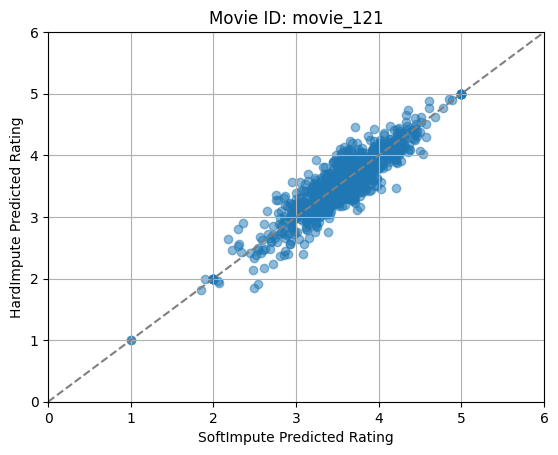

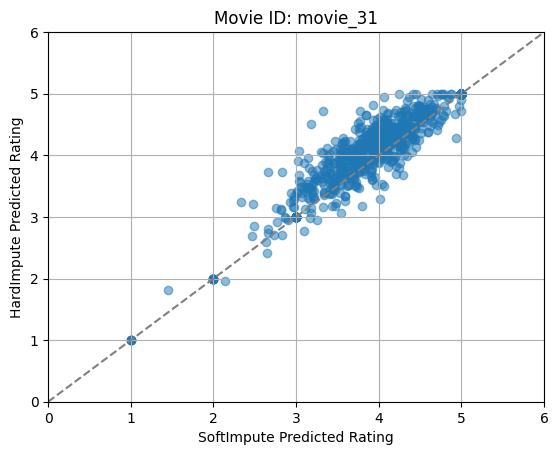

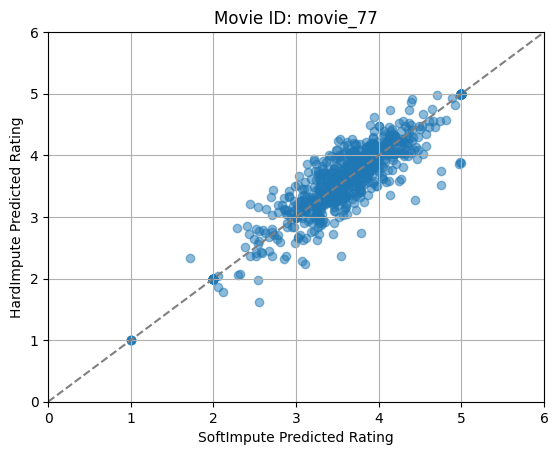

In [ ]:
import matplotlib.pyplot as plt

# Step: Define movie columns to inspect
movie_ids = ['movie_121', 'movie_31', 'movie_77']

for movie_id in movie_ids:
    soft_movie_ratings = soft[movie_id].values
    hard_movie_ratings = hard[movie_id].values

    plt.figure()
    plt.scatter(soft_movie_ratings, hard_movie_ratings, alpha=0.5)
    plt.xlabel('SoftImpute Predicted Rating')
    plt.ylabel('HardImpute Predicted Rating')
    plt.title(f'Movie ID: {movie_id}')
    plt.grid(True)
    plt.plot([0, 6], [0, 6], color='gray', linestyle='--')  # identity line
    plt.xlim(0, 6)
    plt.ylim(0, 6)
    plt.show()

# Plots SH vs NN

(943,)
(943,)


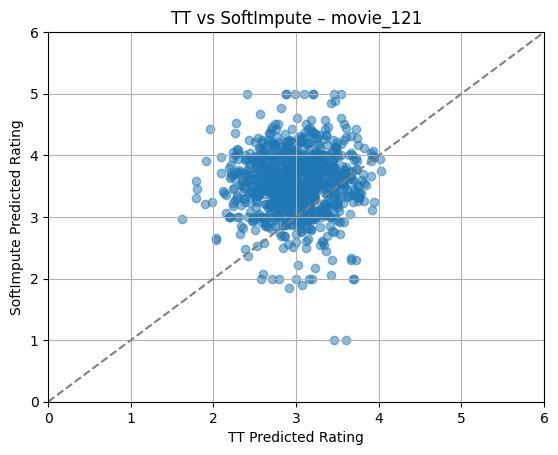

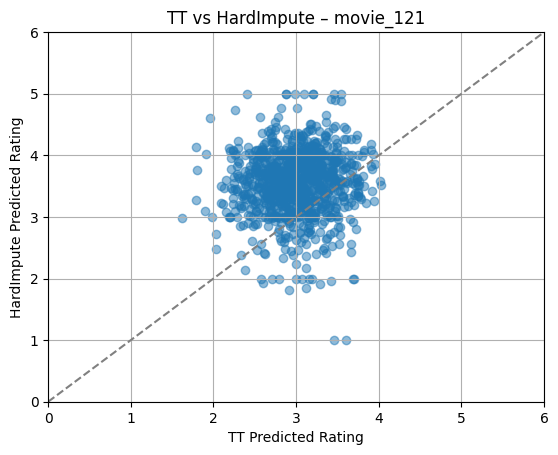

(943,)
(943,)


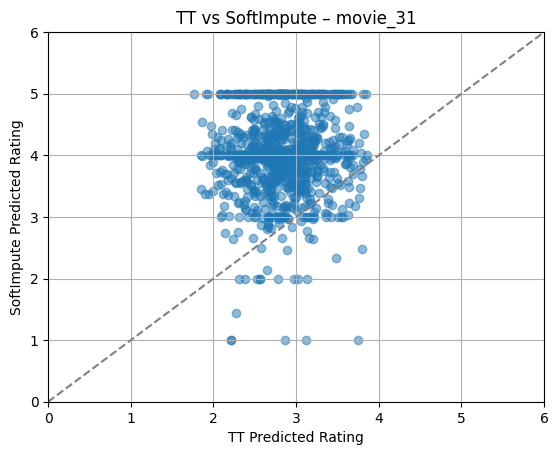

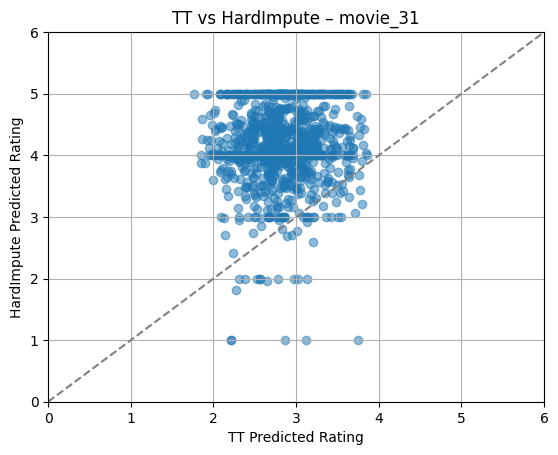

(943,)
(943,)


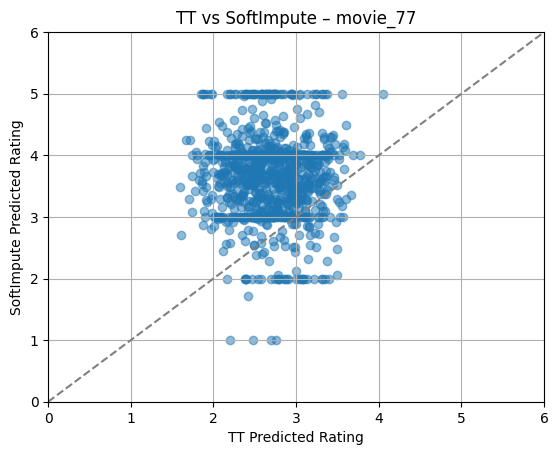

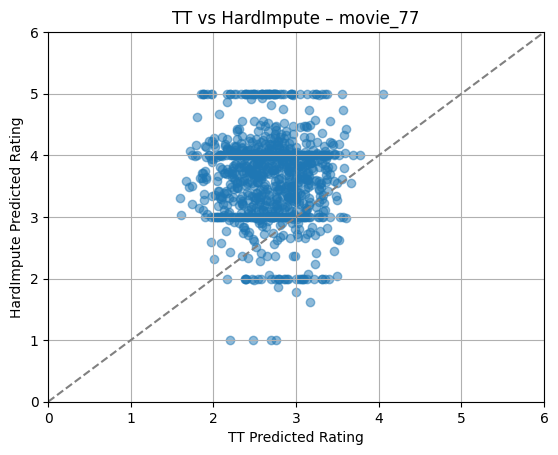

In [ ]:
# Step 1: Ensure column names in TT match Soft/HardImpute
tt = rating_df_scaled.rename(columns={121: 'movie_121', 31: 'movie_31', 77: 'movie_77'})

# Step 2: Plot TT vs SoftImpute and TT vs HardImpute
for movie_id in ['movie_121', 'movie_31', 'movie_77']:
    tt_ratings = tt[movie_id].values
    soft_ratings = soft[movie_id].values
    hard_ratings = hard[movie_id].values
    print(tt_ratings.shape)
    print(soft_ratings.shape)

    # TT vs SoftImpute
    plt.figure()
    plt.scatter(tt_ratings, soft_ratings, alpha=0.5)
    plt.xlabel('TT Predicted Rating')
    plt.ylabel('SoftImpute Predicted Rating')
    plt.title(f'TT vs SoftImpute – {movie_id}')
    plt.grid(True)
    plt.plot([0, 6], [0, 6], color='gray', linestyle='--')  # identity line
    plt.xlim(0, 6)
    plt.ylim(0, 6)
    plt.show()

    # TT vs HardImpute
    plt.figure()
    plt.scatter(tt_ratings, hard_ratings, alpha=0.5)
    plt.xlabel('TT Predicted Rating')
    plt.ylabel('HardImpute Predicted Rating')
    plt.title(f'TT vs HardImpute – {movie_id}')
    plt.grid(True)
    plt.plot([0, 6], [0, 6], color='gray', linestyle='--')  # identity line
    plt.xlim(0, 6)
    plt.ylim(0, 6)
    plt.show()


In [ ]:
from scipy.stats import pearsonr

# Ensure TT movie column names match format in Soft/Hard
tt = rating_df_scaled.copy()
tt.columns = [f"movie_{mid}" for mid in tt.columns]

# Ensure all movies are shared
common_movies = set(tt.columns).intersection(soft.columns).intersection(hard.columns)

# Initialize lists
corr_soft_hard = []
corr_soft_tt = []
corr_hard_tt = []

# Loop over all common movies
for movie_id in common_movies:
    s = soft[movie_id].values
    h = hard[movie_id].values
    t = tt[movie_id].values

    # Compute Pearson correlations
    corr_soft_hard.append(pearsonr(s, h)[0])
    corr_soft_tt.append(pearsonr(s, t)[0])
    corr_hard_tt.append(pearsonr(h, t)[0])

# Convert to arrays
corr_soft_hard = np.array(corr_soft_hard)
corr_soft_tt = np.array(corr_soft_tt)
corr_hard_tt = np.array(corr_hard_tt)

# Print summary statistics
print("Correlation Summary:")
print("Soft vs HardImpute:")
print(f"  Mean: {corr_soft_hard.mean():.4f}, Min: {corr_soft_hard.min():.4f}, Max: {corr_soft_hard.max():.4f}")

print("Soft vs Two-Tower:")
print(f"  Mean: {corr_soft_tt.mean():.4f}, Min: {corr_soft_tt.min():.4f}, Max: {corr_soft_tt.max():.4f}")

print("Hard vs Two-Tower:")
print(f"  Mean: {corr_hard_tt.mean():.4f}, Min: {corr_hard_tt.min():.4f}, Max: {corr_hard_tt.max():.4f}")

Correlation Summary:
Soft vs HardImpute:
  Mean: 0.9240, Min: 0.6211, Max: 1.0000
Soft vs Two-Tower:
  Mean: 0.0008, Min: -0.0903, Max: 0.0951
Hard vs Two-Tower:
  Mean: 0.0013, Min: -0.0925, Max: 0.1070


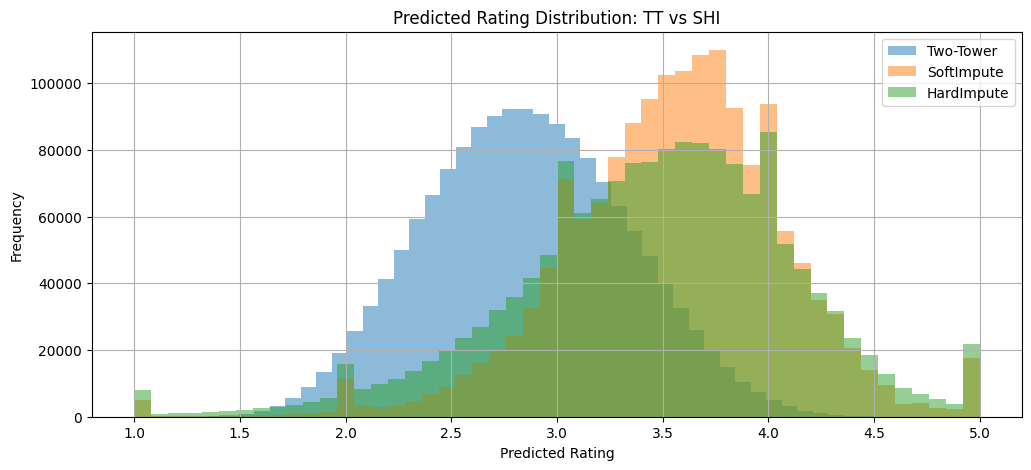

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(rating_df_scaled.values.flatten(), bins=50, alpha=0.5, label='Two-Tower')
plt.hist(soft.values.flatten(), bins=50, alpha=0.5, label='SoftImpute')
plt.hist(hard.values.flatten(), bins=50, alpha=0.5, label='HardImpute')
plt.xlabel("Predicted Rating")
plt.ylabel("Frequency")
plt.title("Predicted Rating Distribution: TT vs SHI")
plt.legend()
plt.grid(True)
plt.show()


## Average corellations

In [ ]:
from scipy.stats import pearsonr

# Ensure TT movie column names match format in Soft/Hard
tt = rating_df_scaled.copy()
tt.columns = [f"movie_{mid}" for mid in tt.columns]

# Ensure all movies are shared
common_movies = set(tt.columns).intersection(soft.columns).intersection(hard.columns)

# Initialize lists
corr_soft_hard = []
corr_soft_tt = []
corr_hard_tt = []

# Loop over all common movies
for movie_id in common_movies:
    s = soft[movie_id].values
    h = hard[movie_id].values
    t = tt[movie_id].values

    # Compute Pearson correlations
    corr_soft_hard.append(pearsonr(s, h)[0])
    corr_soft_tt.append(pearsonr(s, t)[0])
    corr_hard_tt.append(pearsonr(h, t)[0])

# Convert to arrays
corr_soft_hard = np.array(corr_soft_hard)
corr_soft_tt = np.array(corr_soft_tt)
corr_hard_tt = np.array(corr_hard_tt)

# Print summary statistics
print("Correlation Summary:")
print("Soft vs HardImpute:")
print(f"  Mean: {corr_soft_hard.mean():.4f}, Min: {corr_soft_hard.min():.4f}, Max: {corr_soft_hard.max():.4f}")

print("Soft vs Two-Tower:")
print(f"  Mean: {corr_soft_tt.mean():.4f}, Min: {corr_soft_tt.min():.4f}, Max: {corr_soft_tt.max():.4f}")

print("Hard vs Two-Tower:")
print(f"  Mean: {corr_hard_tt.mean():.4f}, Min: {corr_hard_tt.min():.4f}, Max: {corr_hard_tt.max():.4f}")

Correlation Summary:
Soft vs HardImpute:
  Mean: 0.9240, Min: 0.6211, Max: 1.0000
Soft vs Two-Tower:
  Mean: 0.0027, Min: -0.0960, Max: 0.1125
Hard vs Two-Tower:
  Mean: 0.0031, Min: -0.1003, Max: 0.1078


## Average Overlaps

In [ ]:
# Step 1: Rename TT index to match 'user_X' format
tt.index = [f"user_{i}" for i in range(len(tt))]

# Step 2: Define function to get top-k movies per user
def top_k_movies(df, k=10):
    """Returns a dict mapping user_id -> set of top-k movie_ids."""
    return {
        user_id: set(row.sort_values(ascending=False).head(k).index)
        for user_id, row in df.iterrows()
    }

# Step 3: Generate top-10 recommendations for each model
k = 10
top_soft = top_k_movies(soft, k)
top_hard = top_k_movies(hard, k)
top_tt = top_k_movies(tt, k)

# Step 4: Function to compute overlap counts
def compute_overlap(top_a, top_b):
    overlaps = []
    for uid in top_a.keys():  # assumes all user IDs match
        overlap_count = len(top_a[uid].intersection(top_b[uid]))
        overlaps.append(overlap_count)
    return np.array(overlaps)

# Step 5: Compute overlaps
overlap_soft_hard = compute_overlap(top_soft, top_hard)
overlap_soft_tt = compute_overlap(top_soft, top_tt)
overlap_hard_tt = compute_overlap(top_hard, top_tt)

# Step 6: Print summary
print("Top-10 Overlap Summary (Number of Common Movies):")
print(f"Soft vs HardImpute:   Mean = {overlap_soft_hard.mean():.2f}, Min = {overlap_soft_hard.min()}, Max = {overlap_soft_hard.max()}")
print(f"Soft vs Two-Tower:    Mean = {overlap_soft_tt.mean():.2f}, Min = {overlap_soft_tt.min()}, Max = {overlap_soft_tt.max()}")
print(f"Hard vs Two-Tower:    Mean = {overlap_hard_tt.mean():.2f}, Min = {overlap_hard_tt.min()}, Max = {overlap_hard_tt.max()}")

Top-10 Overlap Summary (Number of Common Movies):
Soft vs HardImpute:   Mean = 5.75, Min = 0, Max = 10
Soft vs Two-Tower:    Mean = 0.08, Min = 0, Max = 2
Hard vs Two-Tower:    Mean = 0.08, Min = 0, Max = 2


In [ ]:
top_soft

{'user_0': {'movie_216',
  'movie_289',
  'movie_377',
  'movie_389',
  'movie_431',
  'movie_438',
  'movie_512',
  'movie_550',
  'movie_656',
  'movie_834'},
 'user_1': {'movie_156',
  'movie_172',
  'movie_31',
  'movie_476',
  'movie_506',
  'movie_51',
  'movie_543',
  'movie_746',
  'movie_87',
  'movie_970'},
 'user_2': {'movie_101',
  'movie_158',
  'movie_329',
  'movie_34',
  'movie_357',
  'movie_359',
  'movie_367',
  'movie_52',
  'movie_561',
  'movie_58'},
 'user_3': {'movie_103',
  'movie_111',
  'movie_1619',
  'movie_431',
  'movie_445',
  'movie_492',
  'movie_502',
  'movie_64',
  'movie_77',
  'movie_88'},
 'user_4': {'movie_184',
  'movie_200',
  'movie_265',
  'movie_357',
  'movie_408',
  'movie_51',
  'movie_52',
  'movie_652',
  'movie_719',
  'movie_98'},
 'user_5': {'movie_24',
  'movie_34',
  'movie_357',
  'movie_359',
  'movie_36',
  'movie_367',
  'movie_389',
  'movie_57',
  'movie_622',
  'movie_77'},
 'user_6': {'movie_118',
  'movie_125',
  'movie_3

In [ ]:
top_k = 5
user_ids_to_check = [121, 31, 77]

# Invert index map if needed
index_to_user_id = {idx: uid for uid, idx in user_id_to_index.items()}
user_id_to_row = {uid: idx for idx, uid in enumerate(all_user_ids)}  # for direct row lookup

for uid in user_ids_to_check:
    user_row = user_id_to_row[uid]
    predicted_scores = rating_matrix_scaled_1_5[user_row]

    # Get top k movie indices
    top_k_indices = np.argsort(predicted_scores)[::-1][:top_k]
    top_movie_ids = [all_movie_ids[i] for i in top_k_indices]
    top_scores = predicted_scores[top_k_indices]

    # Get movie titles
    titles = movies.set_index('item_id').loc[top_movie_ids]['movie_title'].values

    print(f"\nTop {top_k} Recommendations for User {uid}:")
    for mid, title, score in zip(top_movie_ids, titles, top_scores):
        print(f"  Movie ID: {mid}, Title: {title}, Predicted Rating: {score:.3f}")


Top 5 Recommendations for User 121:
  Movie ID: 1204, Title: To Be or Not to Be (1942), Predicted Rating: 4.289
  Movie ID: 175, Title: Brazil (1985), Predicted Rating: 4.242
  Movie ID: 493, Title: Thin Man, The (1934), Predicted Rating: 4.210
  Movie ID: 7, Title: Twelve Monkeys (1995), Predicted Rating: 4.175
  Movie ID: 134, Title: Citizen Kane (1941), Predicted Rating: 4.158

Top 5 Recommendations for User 31:
  Movie ID: 1086, Title: It's My Party (1995), Predicted Rating: 4.267
  Movie ID: 218, Title: Cape Fear (1991), Predicted Rating: 4.116
  Movie ID: 888, Title: One Night Stand (1997), Predicted Rating: 4.113
  Movie ID: 1227, Title: Awfully Big Adventure, An (1995), Predicted Rating: 4.041
  Movie ID: 1053, Title: Now and Then (1995), Predicted Rating: 4.001

Top 5 Recommendations for User 77:
  Movie ID: 1334, Title: Somebody to Love (1994), Predicted Rating: 4.317
  Movie ID: 750, Title: Amistad (1997), Predicted Rating: 4.316
  Movie ID: 1634, Title: Etz Hadomim Tafus (

In [ ]:
print("user121 soft:", top_soft['user_121'])
print("user121 hard:", top_hard['user_121'])

user121 soft: {'movie_58', 'movie_166', 'movie_239', 'movie_1077', 'movie_996', 'movie_189', 'movie_342', 'movie_359', 'movie_240', 'movie_221'}
user121 hard: {'movie_166', 'movie_58', 'movie_239', 'movie_1077', 'movie_996', 'movie_189', 'movie_342', 'movie_359', 'movie_240', 'movie_221'}


In [ ]:
print("user31 soft:", top_soft['user_31'])
print("user31 hard:", top_hard['user_31'])

user31 soft: {'movie_36', 'movie_408', 'movie_34', 'movie_544', 'movie_66', 'movie_884', 'movie_77', 'movie_31', 'movie_78', 'movie_694'}
user31 hard: {'movie_544', 'movie_66', 'movie_77', 'movie_78', 'movie_512', 'movie_522', 'movie_694', 'movie_319', 'movie_819', 'movie_1255'}


In [ ]:
print("user77 soft:", top_soft['user_77'])
print("user77 hard:", top_hard['user_77'])

user77 soft: {'movie_216', 'movie_635', 'movie_60', 'movie_49', 'movie_61', 'movie_31', 'movie_209', 'movie_78', 'movie_157', 'movie_102'}
user77 hard: {'movie_311', 'movie_60', 'movie_314', 'movie_49', 'movie_61', 'movie_31', 'movie_101', 'movie_209', 'movie_157', 'movie_102'}
